# G-Mode Signal Filtering and Visualization
### Suhas Somnath
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
5/05/2017

Supplementary Material for Journal paper:
### Rapid mapping of polarization switching through complete information acquisition
**Suhas Somnath, Alex Belianinov, Sergei V. Kalinin & Stephen Jesse** <br>
[Nature Communications](https://www.nature.com/articles/ncomms13290) volume 7, Article number: 13290 (2016) <br>

![notebook_rules.png](../../notebook_rules.png)

Image courtesy of Jean Bilheux from the [neutron imaging](https://github.com/neutronimaging/python_notebooks) GitHub repository.

## Configure the notebook
This notebook is guaranteed to work for the following versions of the G-mode related packages and is **not guaranteed** to work for past or future versions - 
* [pyUSID](https://pycroscopy.github.io/pyUSID/about.html) - Version 0.0.4
* [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) - Version 0.60.1

The following cell should ensure that the necessary packages are installed. 

In [2]:
# Make sure needed packages are installed and up-to-date
import sys

!pip install git+https://github.com/pycroscopy/BGlib.git@gmode_processing
!pip install sidpy pyUSID

#you may have to restart the kernel after installing these packages.

  Cloning https://github.com/pycroscopy/BGlib.git (to revision gmode_processing) to /private/var/folders/gv/bjfmwd1x4dx8021jgtd4mj_m0000gn/T/pip-req-build-yru1fpnj
  Running command git clone --quiet https://github.com/pycroscopy/BGlib.git /private/var/folders/gv/bjfmwd1x4dx8021jgtd4mj_m0000gn/T/pip-req-build-yru1fpnj
  Running command git checkout -b gmode_processing --track origin/gmode_processing
  Switched to a new branch 'gmode_processing'
  Branch 'gmode_processing' set up to track remote branch 'gmode_processing' from 'origin'.
  Resolved https://github.com/pycroscopy/BGlib.git to commit 20a35ade4919f62e23498824c94ff4e5ffbf90d9
  Preparing metadata (setup.py) ... done
  Created wheel for BGlib: filename=BGlib-0.0.3-py2.py3-none-any.whl size=210946 sha256=8ff413d1f09d2318975592c2ba27b7f9085fca84dc760b6b724cb358382de351
  Stored in directory: /private/var/folders/gv/bjfmwd1x4dx8021jgtd4mj_m0000gn/T/pip-ephem-wheel-cache-c68k8i5y/wheels/78/ce/dc/d12e58435b87d4972f3461701ac6874b2dad

In [3]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import, unicode_literals

import sys

# Import necessary libraries:
# General utilities:
from os import path

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Finally, pyUSID and pycroscopy:
import pyUSID as usid

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

save_plots = False

print('Using pyUSID version: {}'.format(usid.__version__))
#print('Using pycroscopy version: {}'.format(px.__version__))

Using pyUSID version: 0.0.10r2


In [4]:
# set up notebook to show plots within the notebook
%matplotlib notebook

## Format the data according to the USID model
Structuring the raw data according to the **Universal Spectroscopy and Imaging Data (USID)** model into a hierarchical data format (HDF or .h5) file gives you access to the fast fitting algorithms and powerful analysis functions within pycroscopy

#### You can load either of the following:
* Any **raw** .mat or .txt parameter files generated from the original experiment - the data will be translated to HDF5 before proceeding with additional processing
* The USID .h5 file generated after the raw data was translated to HDF5

You can select desired file type by choosing the second option in the pull down menu on the bottom right of the file window

In [5]:
input_file_path = r'/Users/rama/Downloads/64/GLine_8V_10kHz_256x256_0001.h5'
folder_path, _ = path.split(input_file_path)

if input_file_path.endswith('.txt'):
    print('Translating raw data to h5. Please wait')
    tran = px.GLineTranslator()
    h5_path = tran.translate(input_file_path)
else:
    h5_path = input_file_path

print('Working on:\n' + h5_path)

Working on:
/Users/rama/Downloads/64/GLine_8V_10kHz_256x256_0001.h5


## Open the .h5 file and inspect its contents:

In [6]:
h5_file = h5py.File(h5_path, 'r+')

print('Datasets and datagroups within the file:\n------------------------------------')
usid.hdf_utils.print_tree(h5_file)

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-FFT_Filtering_000
      --------------------------
      ├ Composite_Filter
      ├ Filtered_Data
      ├ Filtered_Data-Reshape_000
        -------------------------
        ├ Position_Indices
        ├ Position_Values
        ├ Reshaped_Data
        ├ Reshaped_Data-Histogram_Averaging_000
          -------------------------------------
          ├ Averaged_Data
          ├ Averaged_Data-Loop_Fit_000
            --------------------------
            ├ Corrected_Loops
            ├ Loop_Metrics
            ├ Spectroscopic_Indices
            ├ Spectroscopic_Values
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
      ├ Noise_Floors
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


Data in USID is stored in 2D dataset referred to as ``Main`` datasets. In this case, ``Raw_Data`` is the ``Main`` dataset. Four ``ancillary`` datasets (``Spectroscopic_Indices``, ``Spectroscopic_Values``, ``Position_Indices``, ``Position_Values``) support the ``Main`` dataset to provide additional functionality and meaning that will be realized through ``USIDataset`` objects in ``pyUSID``. For additional information and tutorials on these concepts, please see the documentation on the ``pyUSID`` website.

## Get Reference to Raw Data

In [7]:
h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[-1]


h5_main.attrs['quantity'] = 'Deflection'
h5_main.attrs['units'] = 'a.u.'

print(h5_main)

<HDF5 dataset "Raw_Data": shape (254, 4194304), type "<f2">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Deflection (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 254 
Spectroscopic Dimensions: 
	Excitation - size: 4194304
Data Type:
	float16


In [8]:
h5_main = usid.USIDataset(h5_main)

## Extract necessary parameters:

In [9]:
import sidpy as sid

parms_dict = dict(h5_main.parent.parent.attrs)

samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']

pixel_ex_wfm = h5_main.h5_spec_vals[0, :int(h5_main.h5_spec_vals.shape[1]/parms_dict['grid_num_cols'])]

pts_per_pix = pixel_ex_wfm.size
pts_per_line = h5_main.shape[1]

## Inspect the raw data:

<IPython.core.display.Javascript object>


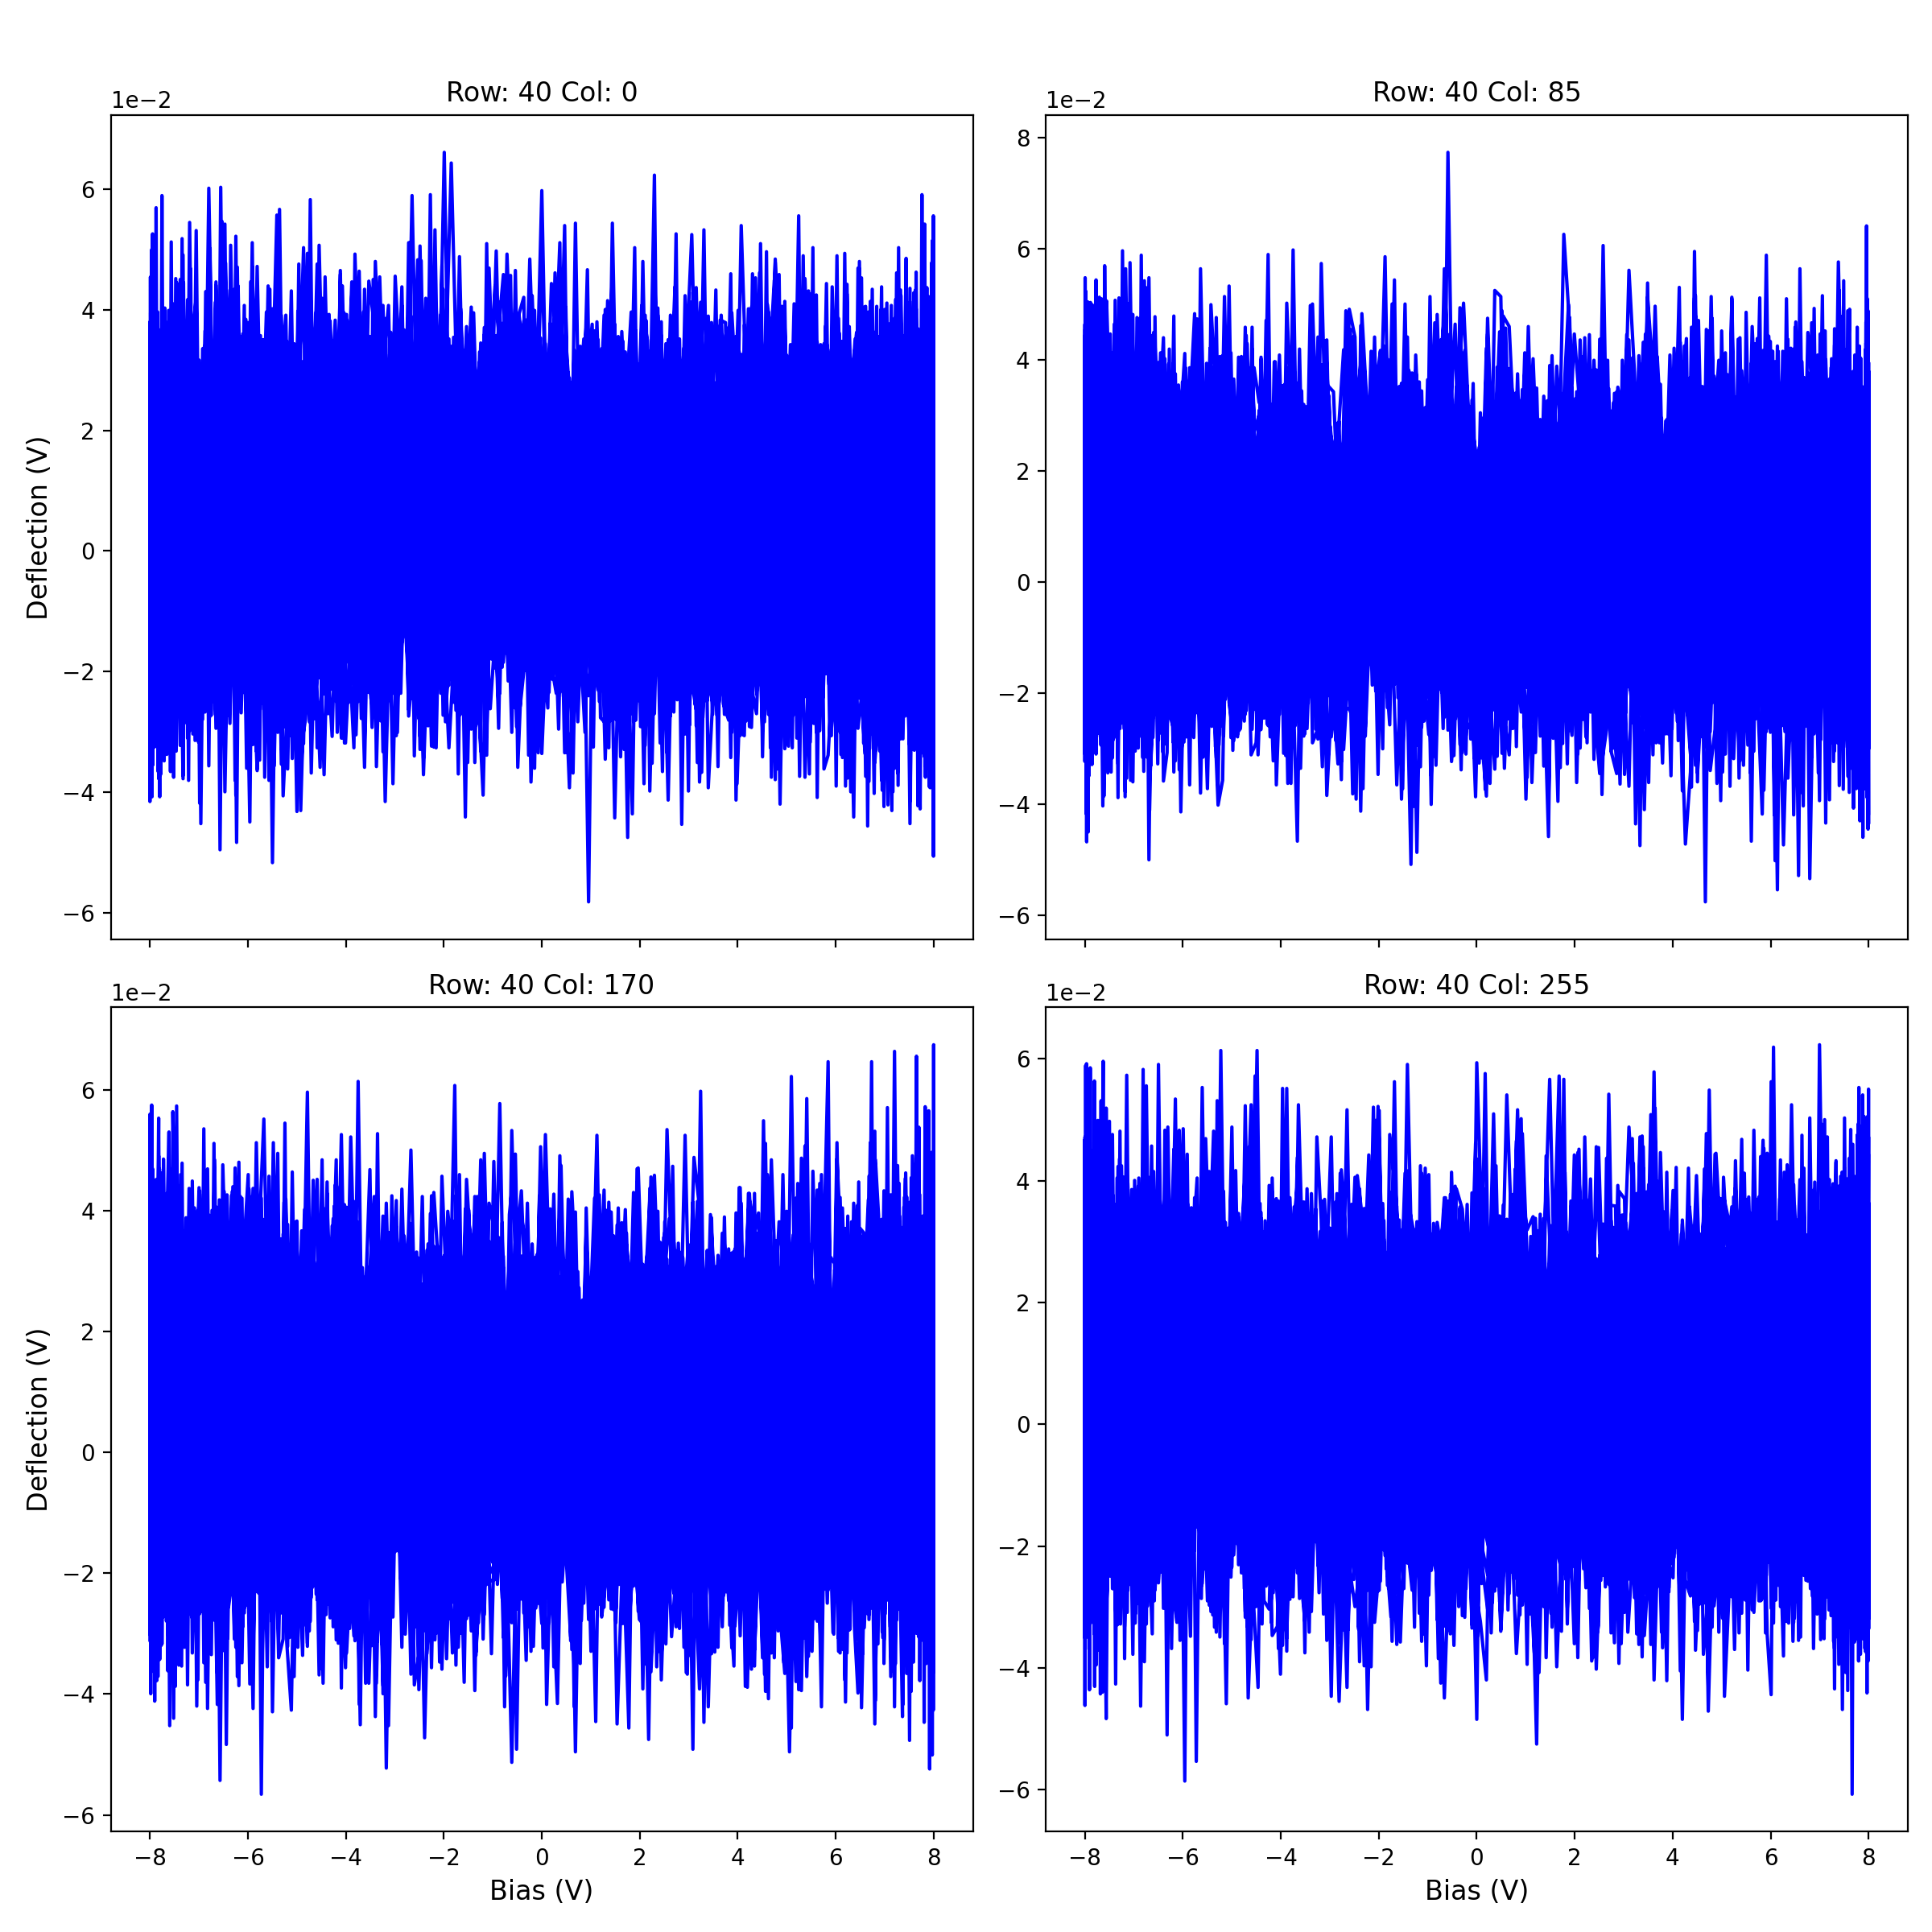

In [10]:
row_ind = 40
raw_row = h5_main[row_ind].reshape(-1, pts_per_pix)

fig, axes = sid.plot_utils.plot_curves(pixel_ex_wfm, raw_row, x_label='Bias (V)', 
                                        y_label='Deflection (V)', title='Raw Measurement',
                                        num_plots=4,  subtitle_prefix='Row: ' + str(row_ind) + ' Col:')

Clearly, the raw data itself is unintelligible. Some filtering is definitely required!

## Visualizing information in Fourier space
Visualizing in the fourier space provides information about the noise floor, frequencies which are noise dominant or signal dominant, etc.

This visualization will guide the design of signal filters to remove the noise

<IPython.core.display.Javascript object>


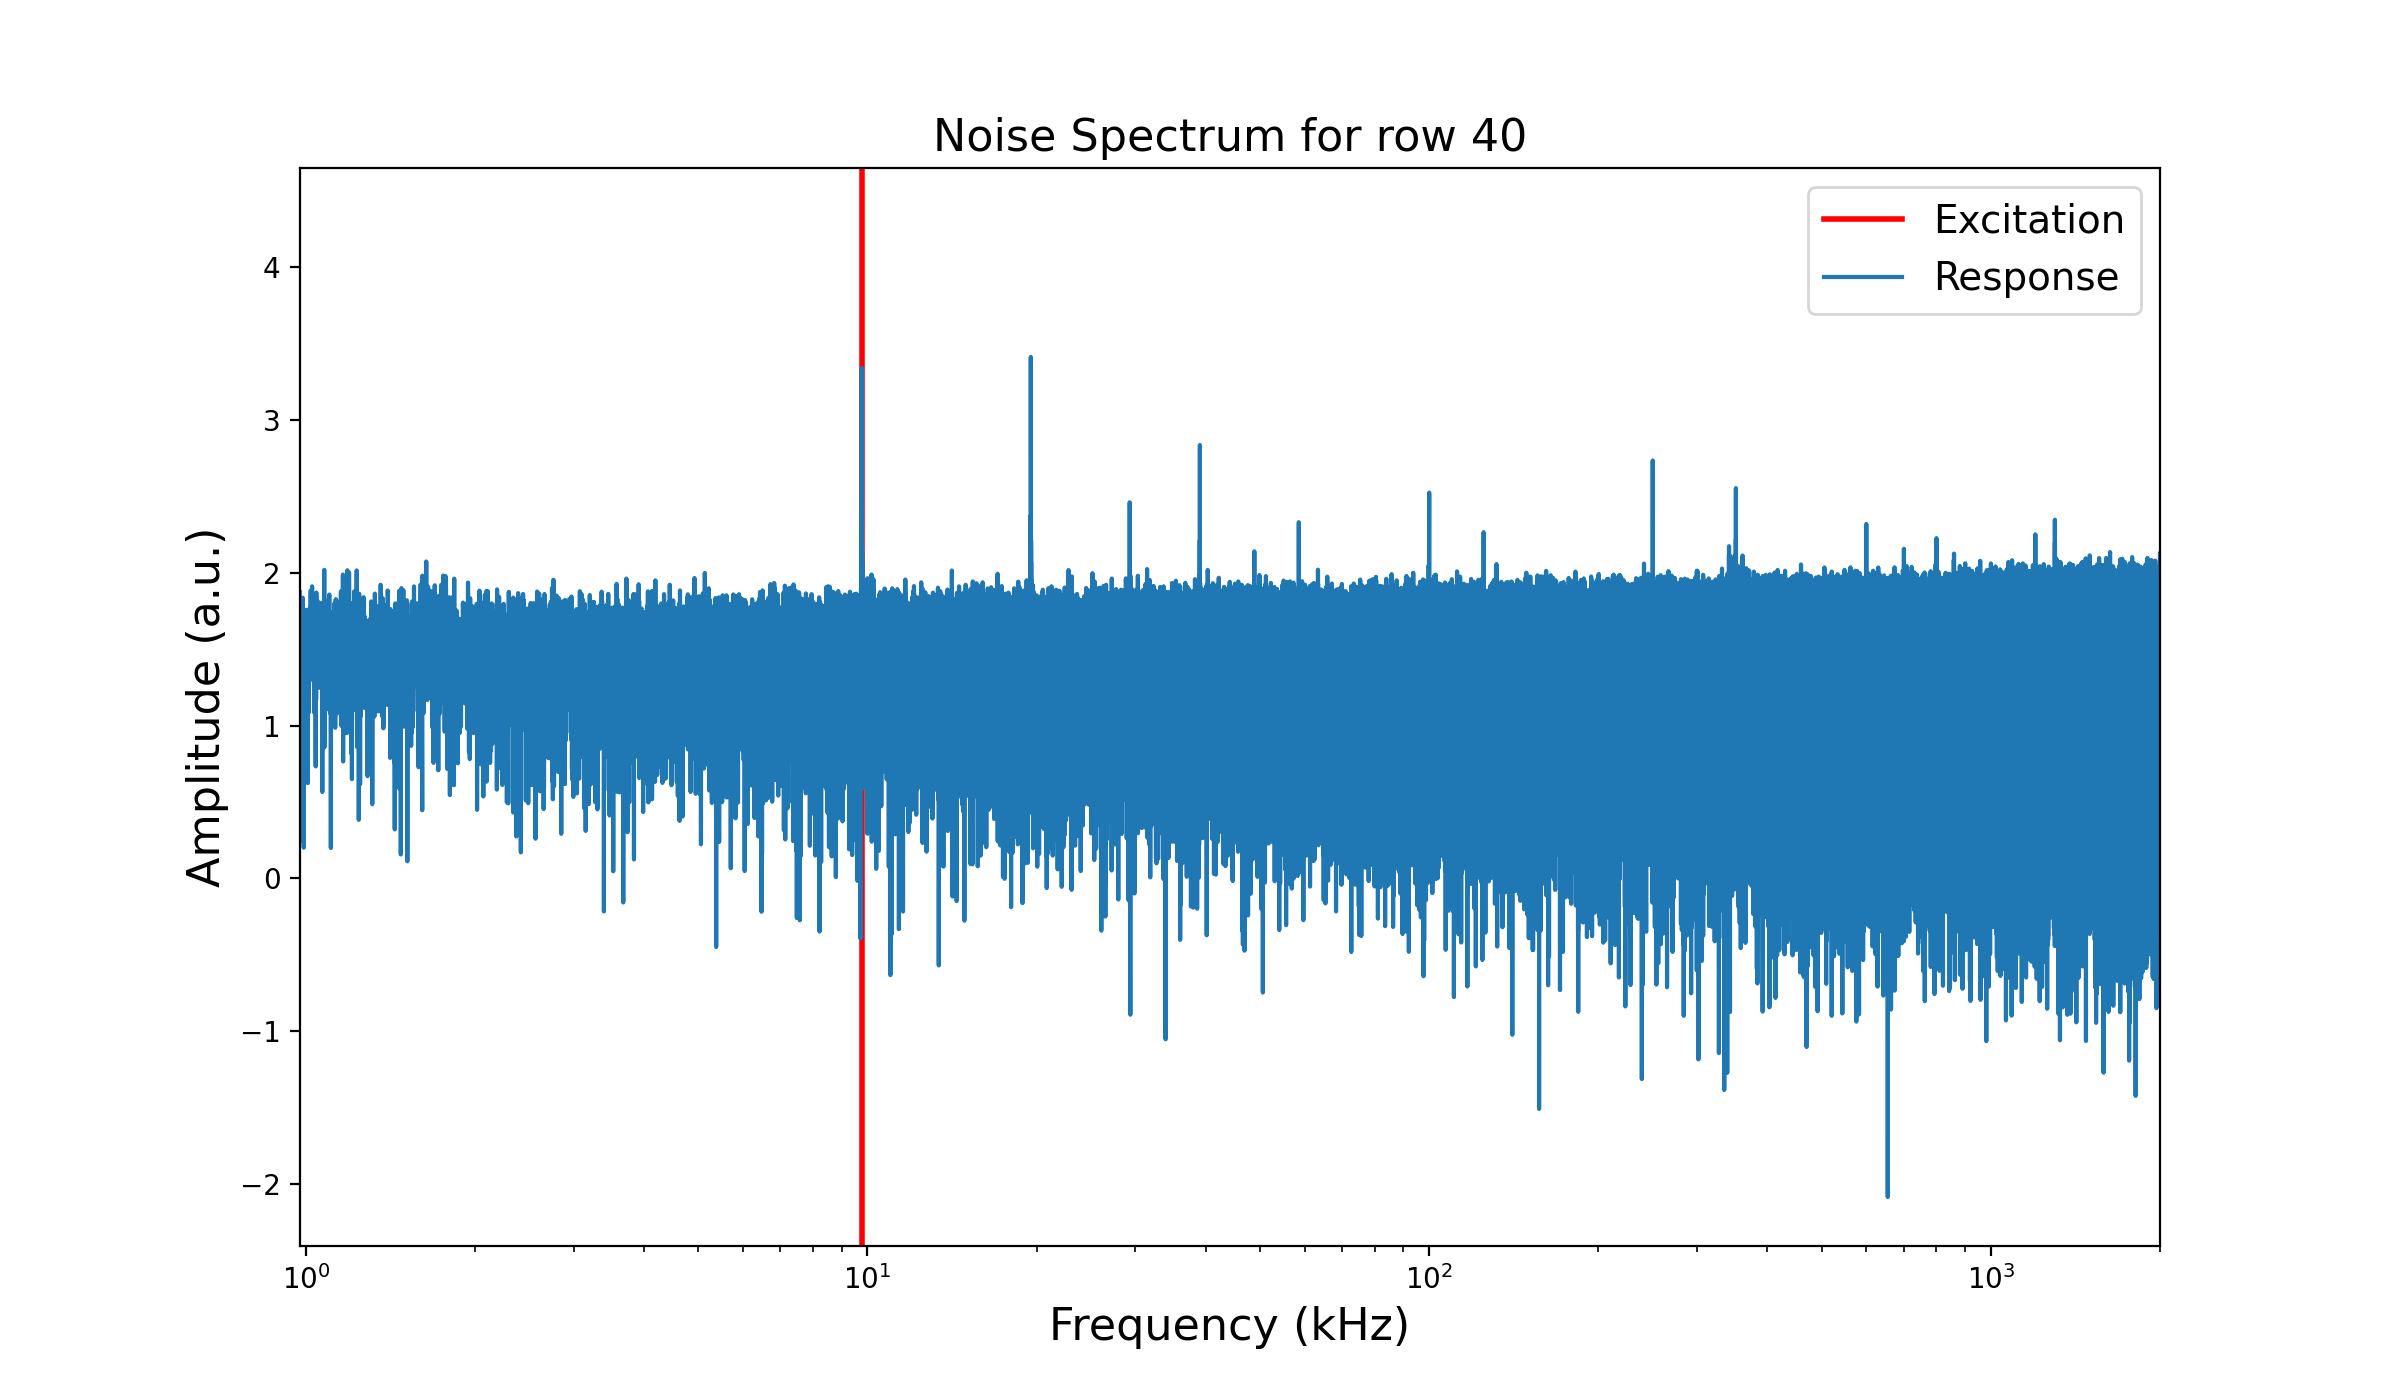

In [11]:
# Preparing the frequency axis:
w_vec = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/pts_per_line, pts_per_line)

row_ind = 40
F_resp = np.fft.fftshift(np.fft.fft(h5_main[row_ind]))
fig, ax = plt.subplots(figsize=(12, 7))
ax.axvline(x=1E-3*ex_freq, color='r', linewidth=2, label='Excitation')
ax.plot(w_vec[int(0.5*len(w_vec)):], np.log10(np.abs(F_resp[int(0.5*len(w_vec)):])), label='Response')
ax.set_xlabel('Frequency (kHz)', fontsize=16)
ax.set_ylabel('Amplitude (a.u.)', fontsize=16)
ax.legend(fontsize=14)
ax.set_xscale('log')
ax.set_xlim(ex_freq*1E-4, samp_rate*0.5E-3)
ax.set_title('Noise Spectrum for row ' + str(row_ind), fontsize=16)
#px.plot_utils.set_tick_font_size(ax, 14)
if save_plots:
    fig.savefig(os.path.join(other_figures_folder, 
                             'noise_spectrum_line_' + str(row_ind) +'.png'), 
                format='png', dpi=150);

## Try different FFT filters on the data

Pycroscopy has an object caled **SignalFilter** that handles some common frequency-domain filters. We will be passing different combinations of filter objects to filter the data. 

Below, we use a handy utility called **partial** to preconfigure the constant portions of the individual filter objects such as the length of the signal, excitation frequency, sampling rate, etc. 

Good combinations for frequency filters are:
* Just a HarmonicPassFilter
* LowPassFilter + NoiseBandFilter

It is always a good idea to combine these frequency filters with noise thresholding. Try setting noise tolerance values of 1E-6 to 1E-3

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
Group: <HDF5 group "/Measurement_000/Channel_000/Raw_Data-FFT_Filtering_000" (4 members)> had neither the status HDF5 dataset or the legacy attribute: "last_pixel".


<IPython.core.display.Javascript object>


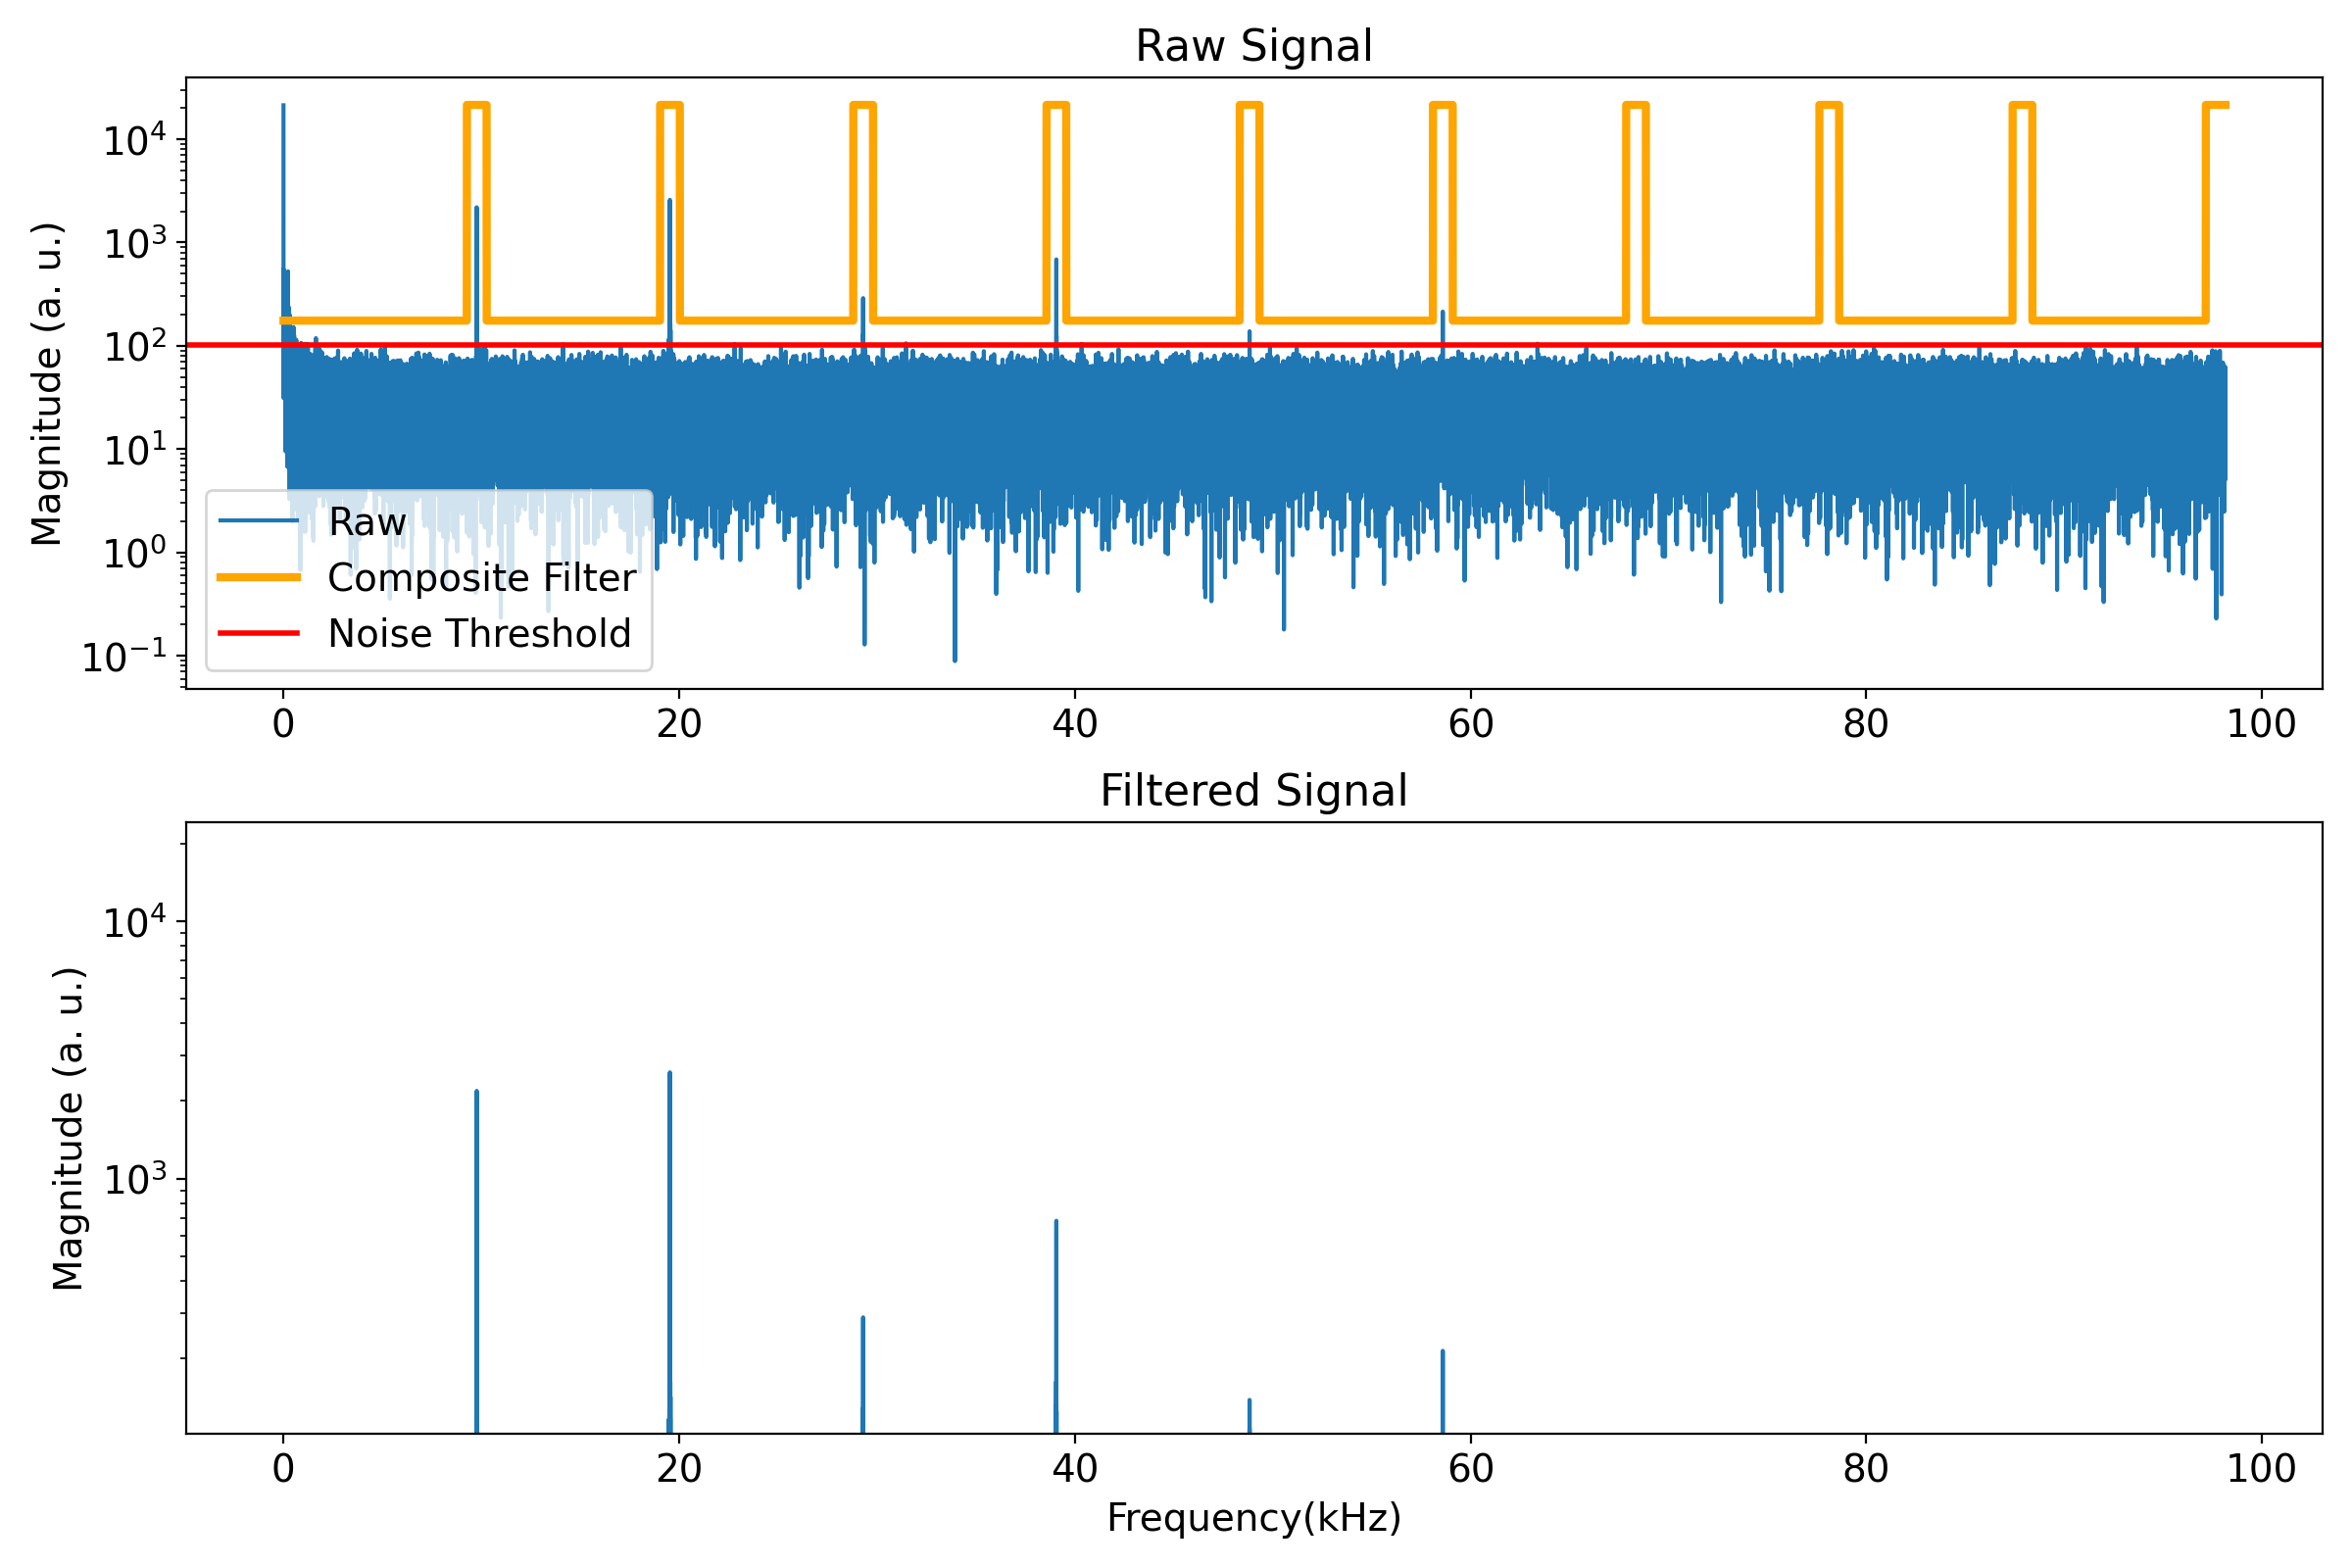

(256, 16384) (256, 16384)


<IPython.core.display.Javascript object>


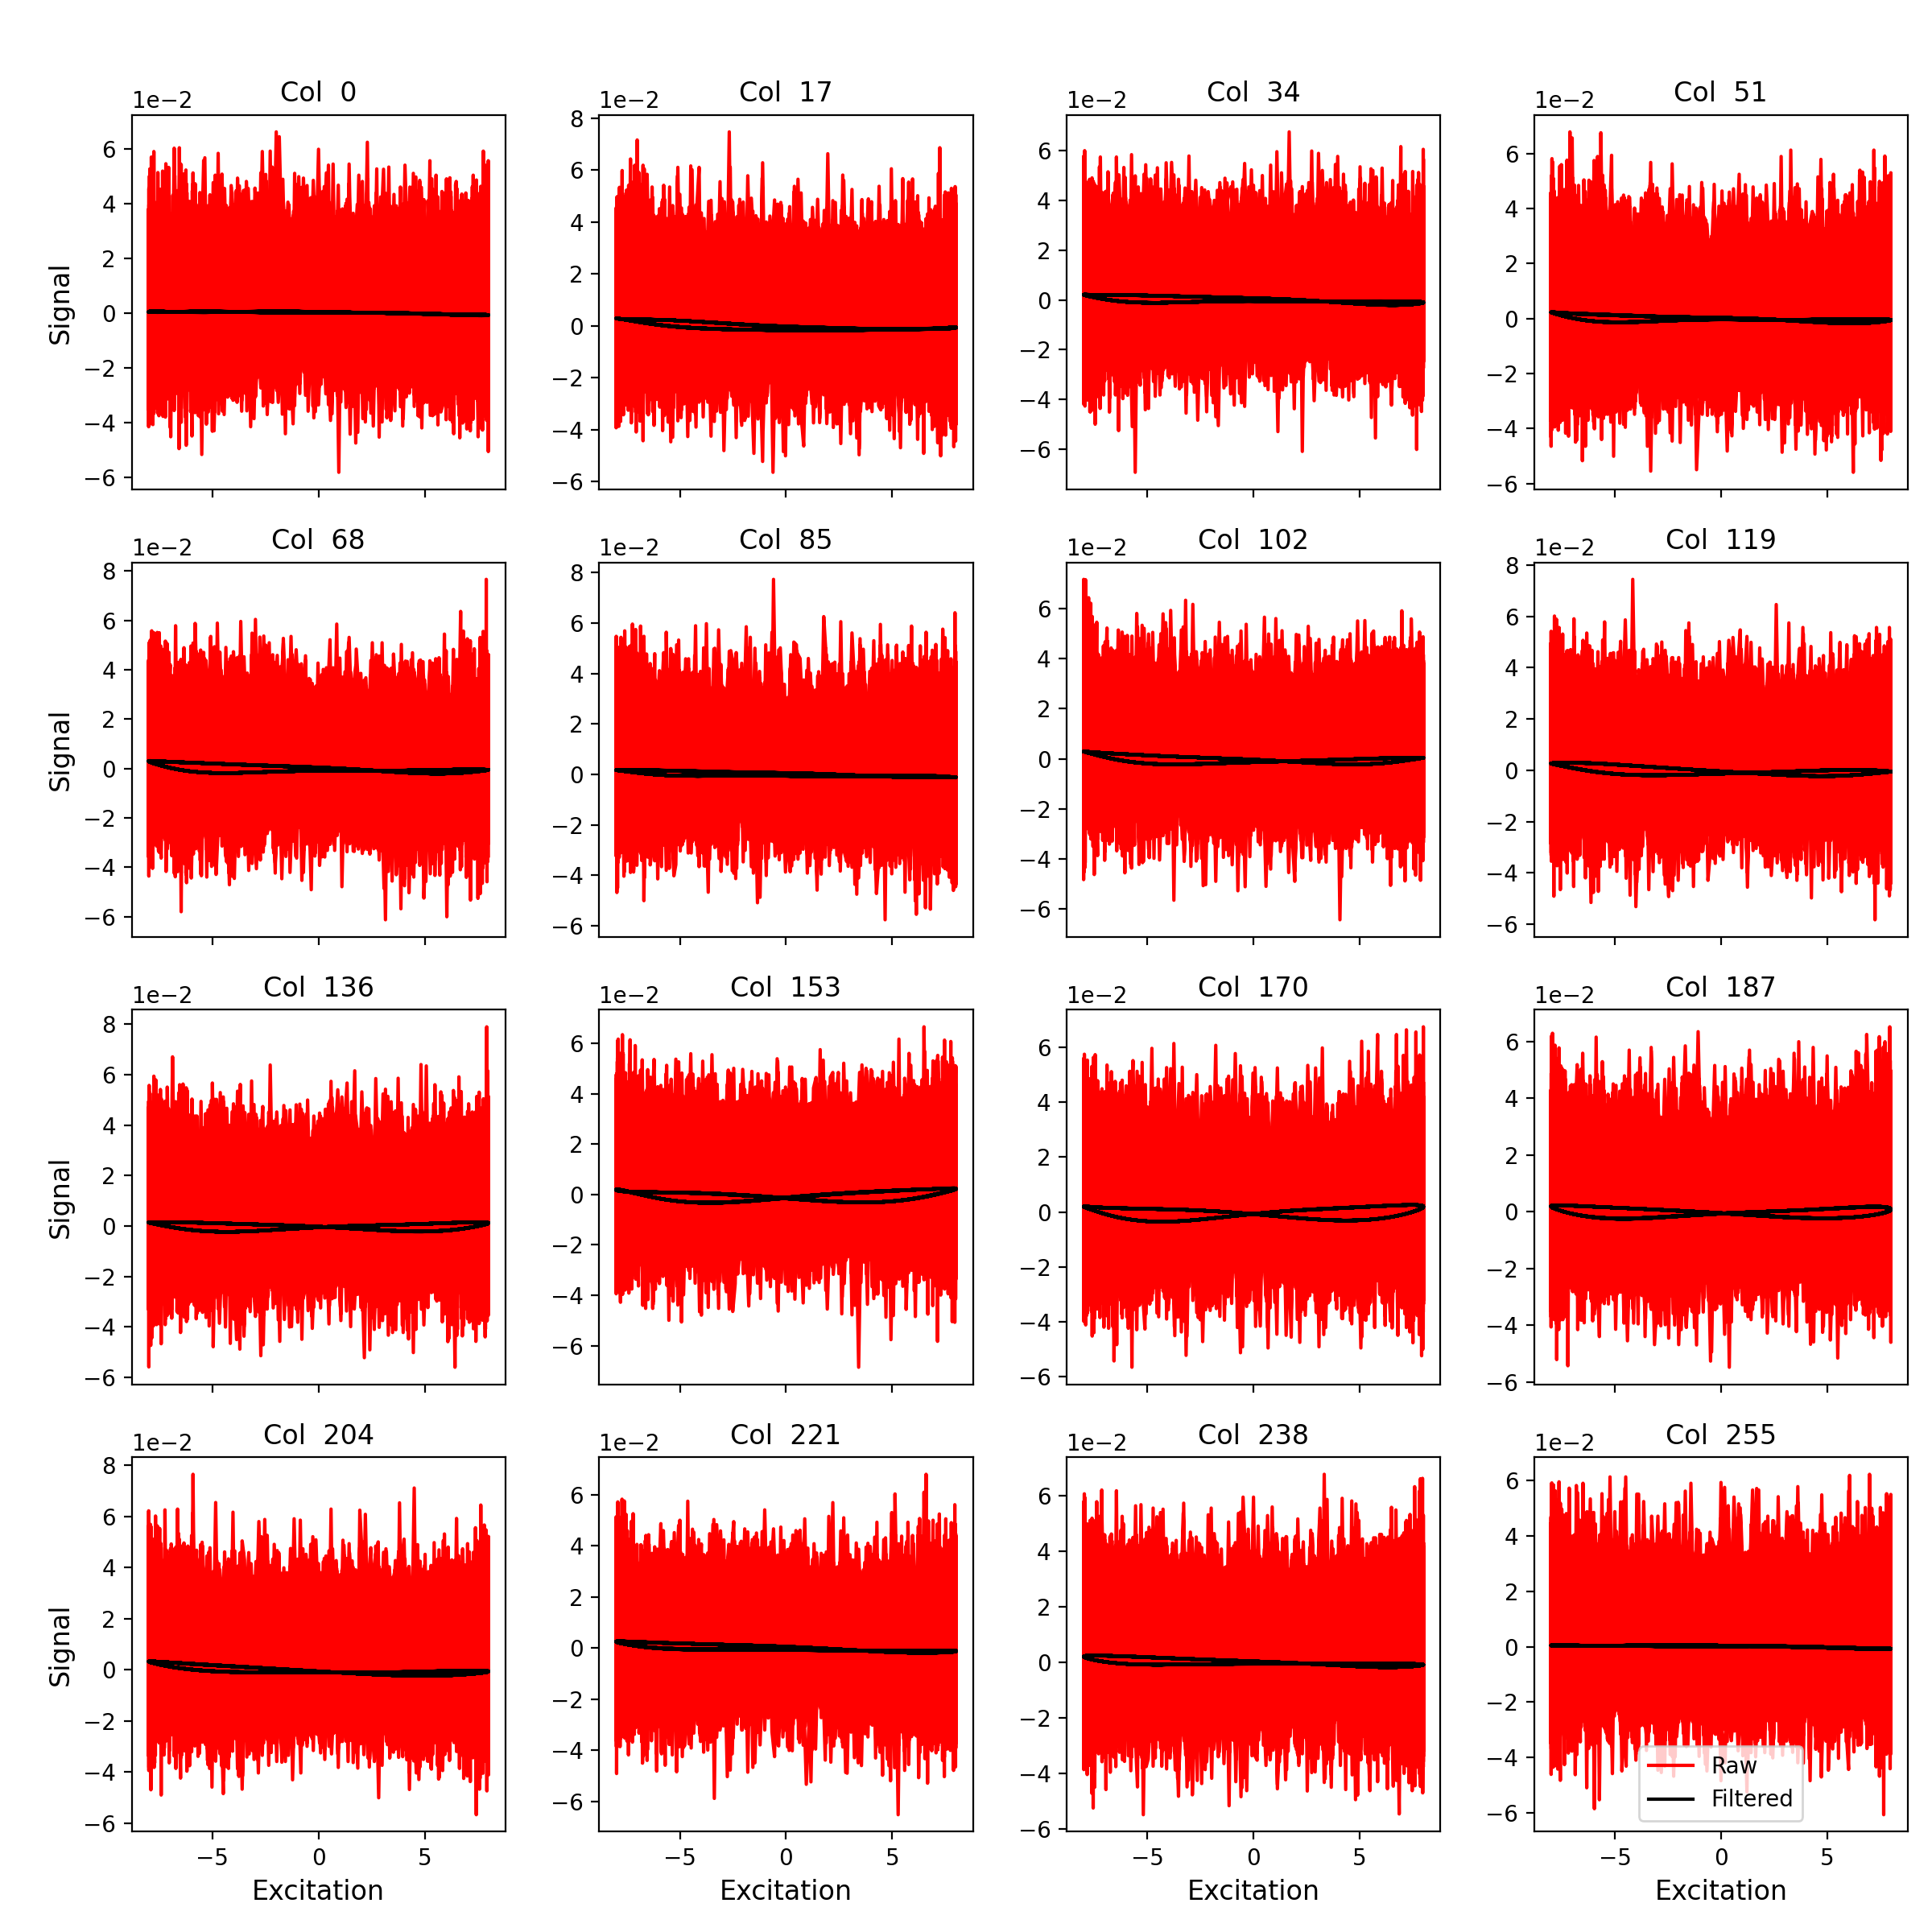

In [12]:
from functools import partial
from BGlib.gmode.proc.fft import HarmonicPassFilter, LowPassFilter, NoiseBandFilter

# Pre-configuring filters here:
p_hpf = partial(HarmonicPassFilter, signal_length=pts_per_line, 
                samp_rate=samp_rate, first_freq=ex_freq)
p_lpf = partial(LowPassFilter, signal_length=pts_per_line, 
                samp_rate=samp_rate)
p_nbf = partial(NoiseBandFilter, signal_length=pts_per_line, 
                samp_rate=samp_rate)

# Now only provide the custom values for the individual filter functions:
hpf = p_hpf(band_width=1E+3, num_harm=10)
lpf = p_lpf(f_cutoff=110E+3)
nbf = p_nbf(freqs=[0], freq_widths=[17E+3])

# Now pick the combination of filters that will be used
filter_combo = [hpf]
noise_thresh = 1E-4

# Initialize the SignalFilter object that will actually apply the filters:
from BGlib.gmode.proc.signal_filter import SignalFilter
#cleaner = px.processing.SignalFilter(h5_main, frequency_filters=filter_combo, noise_threshold=noise_thresh, 
#                                     num_pix=1, write_filtered=True, write_condensed=False)

cleaner = SignalFilter(h5_main, frequency_filters=filter_combo, noise_threshold=noise_thresh, 
                                     num_pix=1, write_filtered=True, write_condensed=False)

# Test filter on a single line:
row_ind = 40
filt_row, fig_fft, fig_loops = cleaner.test(pix_ind=row_ind, excit_wfm=pixel_ex_wfm)

if save_plots:
    fig_fft.savefig(path.join(folder_path, 'FFT_filter_on_line_{}.png'.format(row_ind)), format='png', dpi=300)

## Visualizing the filtered loops more closely:

<IPython.core.display.Javascript object>


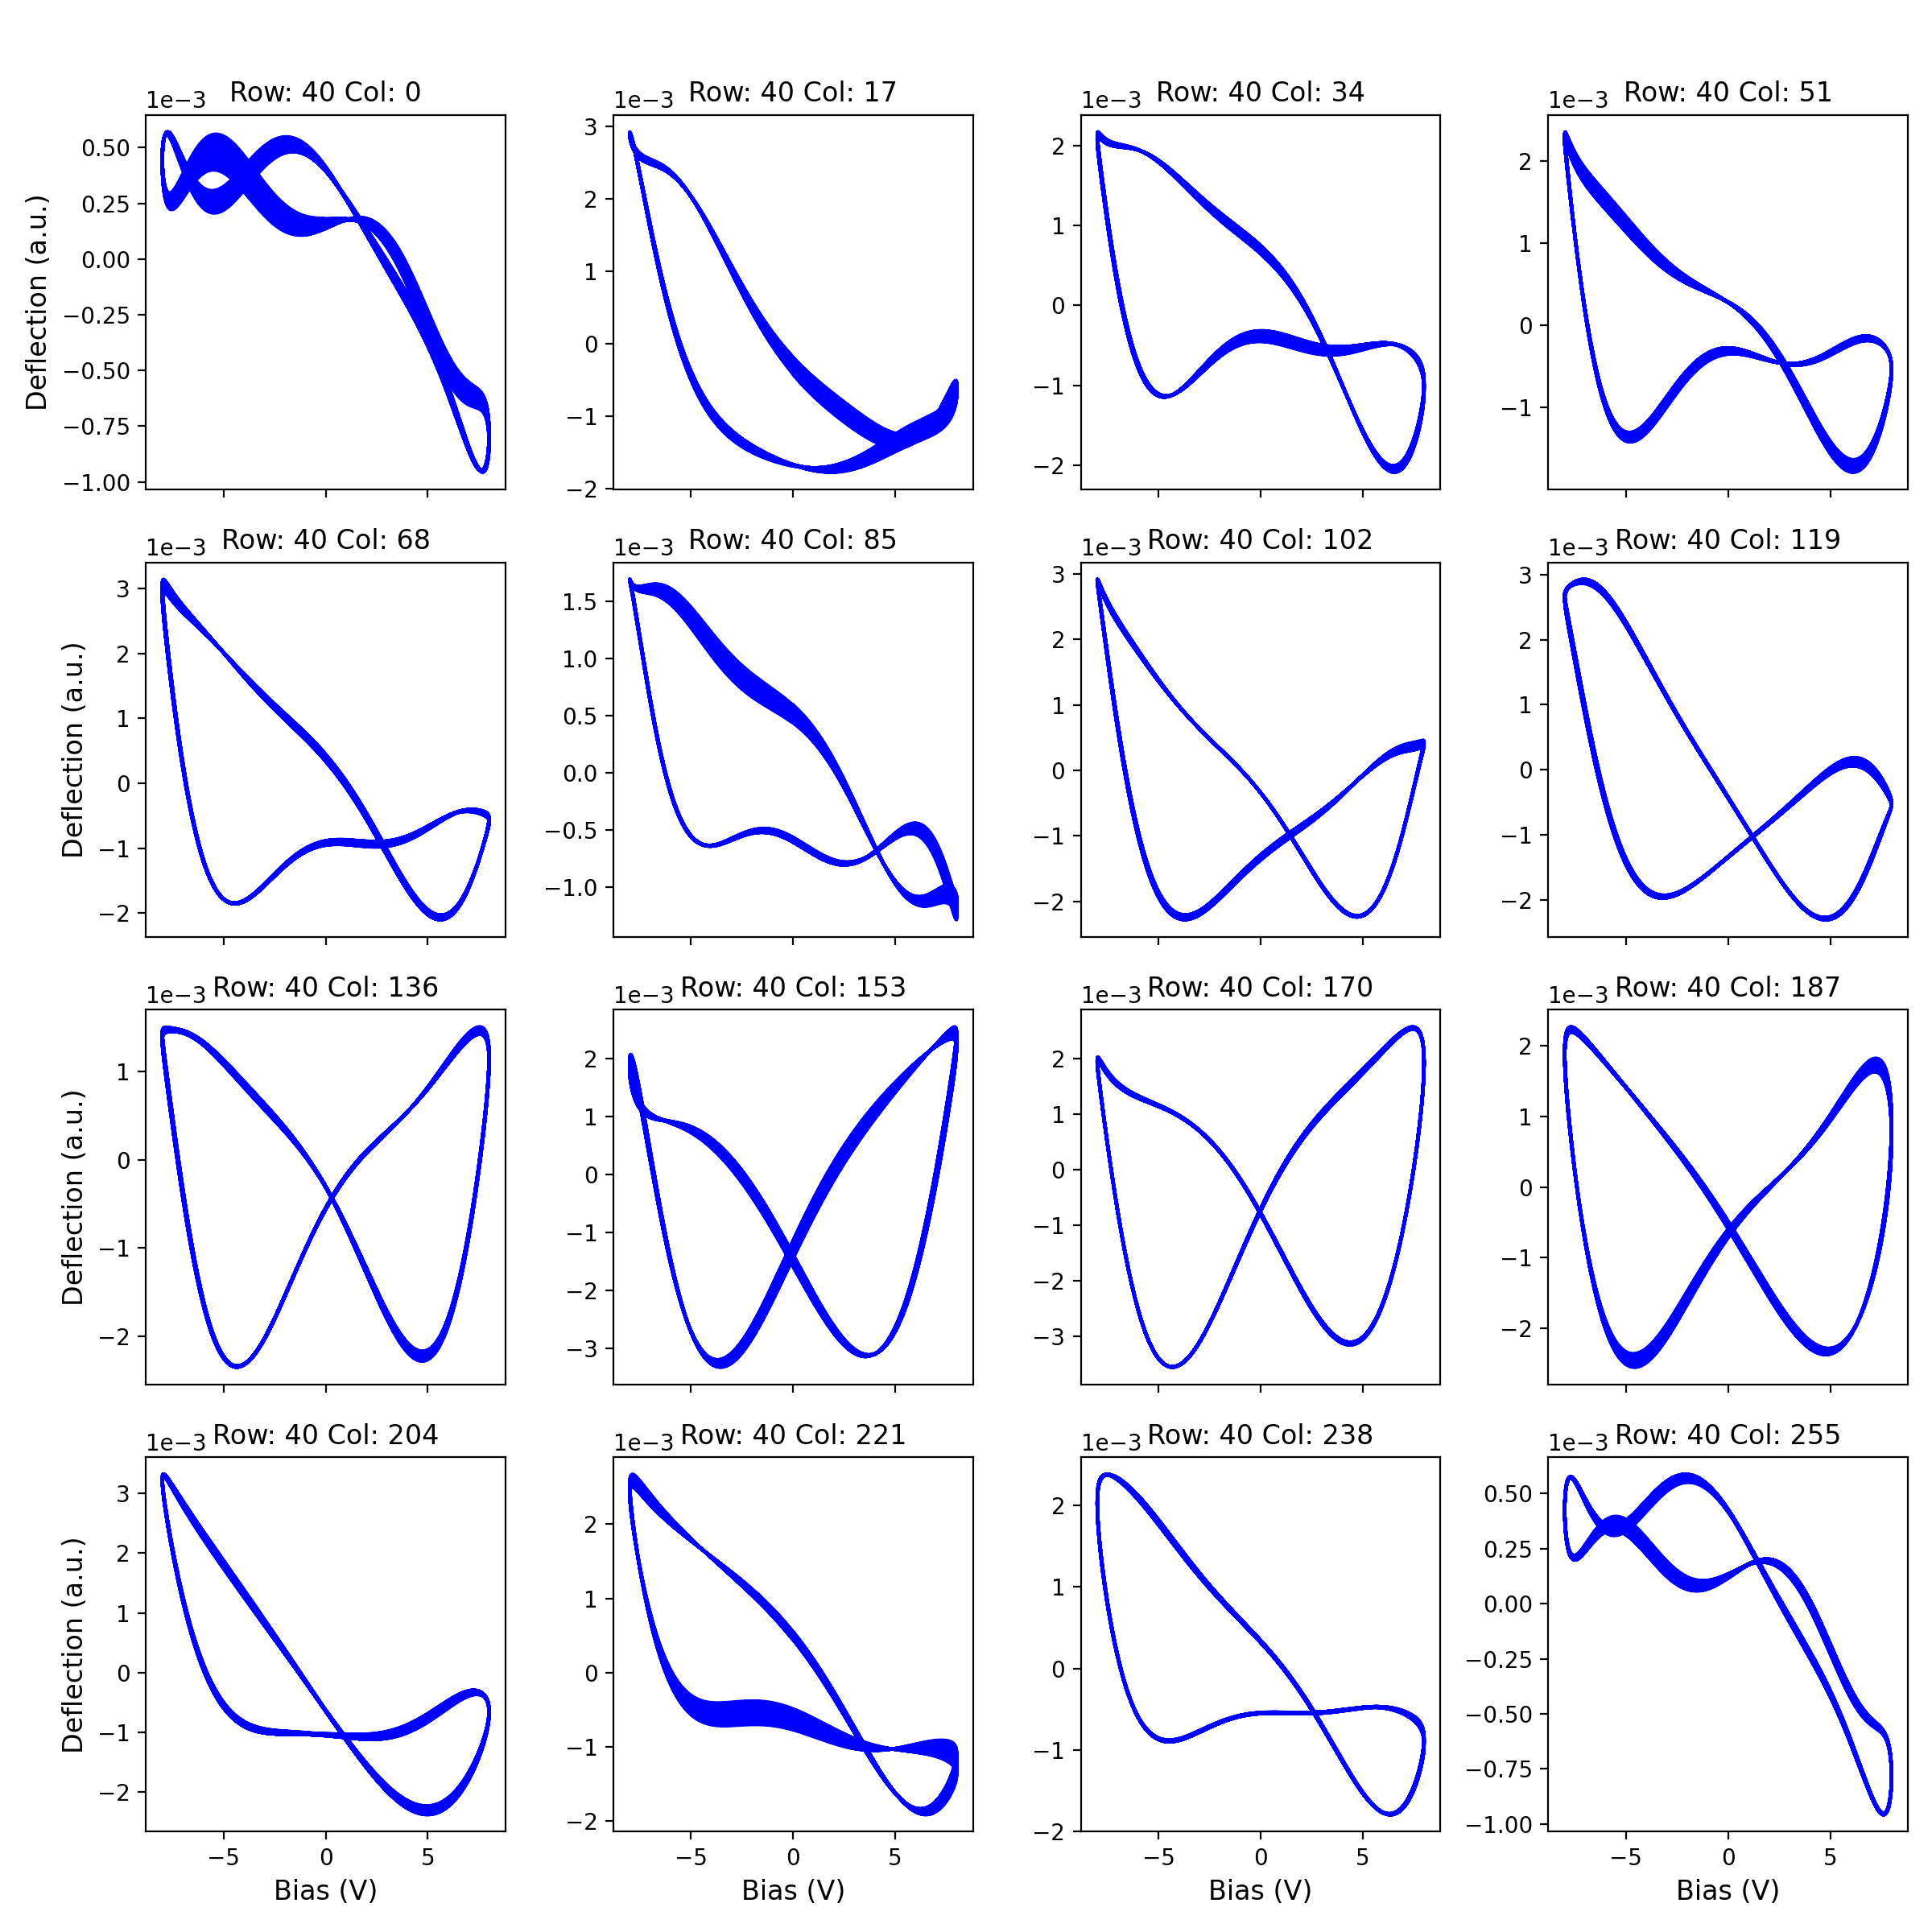

In [13]:
filt_pixels = filt_row.reshape(-1, pixel_ex_wfm.size)
fig, axes = sid.plot_utils.plot_curves(pixel_ex_wfm, filt_pixels, x_label='Bias (V)', title='FFT Filtering',
                                        num_plots=16, y_label='Deflection (a.u.)',
                                        subtitle_prefix='Row: ' + str(row_ind) + ' Col:')
if save_plots:
    fig.savefig(path.join(folder_path, 'FFT_filtered_loops_on_line_{}.png'.format(row_ind)), format='png', dpi=300)

## Apply selected filter to entire dataset

In [ ]:
h5_filt_grp = cleaner.compute()
h5_filt = h5_filt_grp['Filtered_Data']

In [ ]:
# Test to make sure the filter gave the same results
filt_pixels = h5_filt[row_ind].reshape(-1, pixel_ex_wfm.size)
fig, axes = usid.plot_utils.plot_curves(pixel_ex_wfm, filt_pixels, x_label='Bias (V)', title='FFT Filtering',
                                        num_plots=16, y_label='Deflection (a.u.)',
                                        subtitle_prefix='Row: ' + str(row_ind) + ' Col:')

## Now break up the filtered lines into "pixels"
Also visualize loops from different pixels

In [ ]:
# h5_resh = h5_filt_grp['Filtered_Data-Reshape_000/Reshaped_Data']
h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_filt, pixel_ex_wfm.size, 1)
fig, axes = px.plot_utils.plot_loops(pixel_ex_wfm, h5_resh, x_label='Bias (V)', title='FFT Filtering',
                                     plots_on_side=5, y_label='Deflection (a.u.)')
# fig.savefig(path.join(folder_path, 'FFT_filtered_loops_on_line_{}.png'.format(row_ind)), format='png', dpi=300)

In [ ]:
hdf.close()